# Facility Location Problem

This formulation is based on the following paper

J.E.Beasley. ``An algorithm for solving large capacitated warehouse location problems''. European Journal of Operational Research 33 (1988) 314-325.

The input [cap41.txt](https://github.com/avinashu1980/Intro_Python_Gurobi/blob/master/cap41.txt) file corresponds to the standard cap41 dataset available at: http://people.brunel.ac.uk/~mastjjb/jeb/orlib/capinfo.html

Make sure the input file is in the same folder as the python script or the notebook. The following set of codes, read the input file and initialize the corresponding parameters.

In [1]:
from gurobipy import *

f = open("cap41.txt", "r")
line = f.readline() 
data = line.split()
num_loc = int(data[0])
num_cust = int(data[1])
loc = list(range(num_loc))
cust = list(range(num_cust))
cap = []
fc = []
dem = []
vc = []
for i in loc:
    line = f.readline() 
    data = line.split()
    cap.append(int(data[0]))
    fc.append(float(data[1]))
for i in cust:
    line = f.readline()
    dem.append(int(line))
    line = f.readline()
    data = line.split()
    for j in loc:
        vc.append([])
        vc[i].append(float(data[j]))
f.close()

We first setup a gurobi model. 

In [2]:
m = Model("facility location")

We create two sets of variables. The binary y variable corresponds to whether a facility is opened or not. The x[i][j] variable provides the fraction of demand of customer i which is met by facility j.

In [3]:
y = []
for i in loc:
    y.append(m.addVar(vtype=GRB.BINARY, obj=fc[i],  name="open[%d]" % i))
    
x = []
for i in cust:
    x.append([])
    for j in loc:
        x[i].append(m.addVar(obj=vc[i][j], lb = 0, ub = 1, name="trans[%d,%d]" % (i, j)))

There are other ways to initialize the variables which is shown below.

In [4]:
#y = m.addVars(num_loc, vtype=GRB.BINARY, obj=fc, name="open")
#x = m.addVars(num_cust, num_loc, obj=vc, lb = 0, ub = 1, name="trans")
#x = []
#for i in cust:
#    for j in loc:
#        x[i][j] = m.addVar(obj=vc[i][j], lb = 0, ub = 1, name="trans[%d,%d]" % (i, j))



In [5]:
m.modelSense = GRB.MINIMIZE

We will add three sets of constraints. The first set of constraints ensures that all the customers demands are met.

In [6]:
for i in cust:
    m.addConstr(sum(x[i][j] for j in loc) == 1, "Demand[%d]" % i)

The second set of constraints ensure that the sum of the demand served by each facility is less than or equal to the capacity. Also the constraint ensures that no customer is served from a closed facility.

In [7]:
for j in loc:
     m.addConstr(sum(dem[i]*x[i][j] for i in cust) <= cap[j]*y[j], "Capacity[%d]" % j)

The third set of constraints is not really needed and is added to improve the computational speed. You will not notice the difference for this particular example. This constraint also ensures that no customer is served from a closed facility.

In [8]:
for i in cust:
    for j in loc:
        m.addConstr(x[i][j] <= y[j], "Feasibility[%d][%d]" %(i,j))

Next we optimize the model.

In [9]:
m.optimize()

Optimize a model with 866 rows, 816 columns and 3216 nonzeros
Variable types: 800 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [5e+02, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2.06359e+06
Presolve removed 80 rows and 1 columns
Presolve time: 0.01s
Presolved: 786 rows, 815 columns, 3055 nonzeros
Variable types: 800 continuous, 15 integer (15 binary)

Root relaxation: objective 1.040444e+06, 103 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1040444.3750 1040444.38  0.00%     -    0s

Explored 0 nodes (103 simplex iterations) in 0.03 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 1.04044e+06 2.06359e+06 
Pool objective bound 1.04044e+06

Optimal solution found (tolera

The following lines of code is to write the solution to a file called output.txt which should be in the same directory in which you created the notebook.

In [10]:
f = open("output.txt", "w")
f.write('\nTOTAL COSTS: %g' % m.objVal)
f.write('\nSOLUTION:')
for j in loc:
    if y[j].x > 0.99:
        f.write('\nPlant %s open' % j)
        for i in cust:
            if x[i][j].x > 0:
                f.write('\n Transport %g units to customer %s' % (x[i][j].x, i))
    else:
        f.write('\n Plant %s closed!' % i)
f.close()

The following lines of code are help us in visualizing the solution. The customer and facility locations are generated randomly. The customer locations are white in color whereas the open facilities are the red nodes. We use the matplotlib and networkx packages. While the visualization is not clean as we have too many customers, for smaller number of customers, it would generate good insights.

Number of nodes:  63
Number of nodes:  63


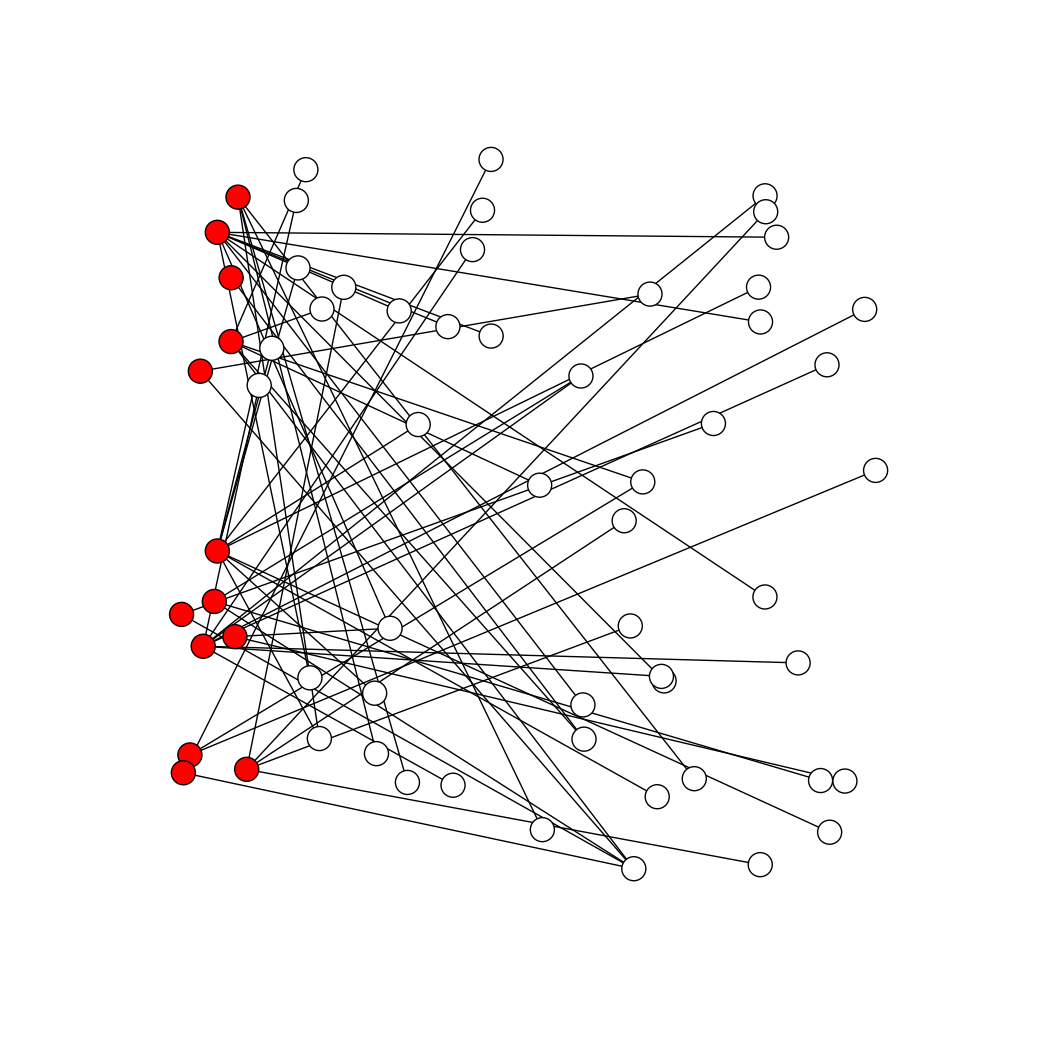

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(10,10))

cust_x = [random.uniform(1,10) for i in cust]
cust_y = [random.uniform(0,10) for i in cust]

fac_x = [random.uniform(0,1) for i in loc]
fac_y = [random.uniform(0,10) for i in loc]

connection = [(i,50+j) for i in cust for j in loc if x[i][j].x > 0]
fac_nodes = [j for j in loc if y[j].x > 0]
cust_nodes = [i for i in cust]

G = nx.Graph()
G.add_edges_from(connection)

for i in cust:
    G.add_node(i, pos = (cust_x[i], cust_y[i]))

print("Number of nodes: ", G.number_of_nodes())
    
for i in loc:
    if y[i].x > 0:
        G.add_node(50+i, pos = (fac_x[i],fac_y[i]) )

print("Number of nodes: ", G.number_of_nodes())       
#node_col = nx.get_node_attributes(G,'color')
node_col = ['white' if node < len(cust) else 'red' for node in G.nodes()]

node_pos=nx.get_node_attributes(G,'pos')

#nx.draw_networkx(G,node_pos, node_color = node_col)
nx.draw(G,node_pos, node_color = node_col)
#nx.draw_networkx_edges(G, node_pos)
#plt.axis('off')
# Show the plot
plt.show()